In [ ]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

In [2]:
import gym
import os
import sys
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime
from q_learning import plot_running_avg, FeatureTransformer, plot_cost_to_go

In [3]:
# helper for adam optimizer
# use tensorflow defaults
def adam(cost, params, lr0= 1e-3, beta1= 0.9, beta2= 0.999, eps= 1e-8):
    grads = T.grad(cost,params)
    updates = []
    time = theano.shared(0)
    new_time = time + 1
    updates.append((time, new_time))
    lr = lr0 * T.sqrt(1 - beta2**new_time) / (1 - beta1**new_time)
    for p, g in zip(params, grads):
        m = theano.shared(p.get_value() * 0.)
        v = theano.shared(p.get_value() * 0.)
        new_m = beta1*m + (1 - beta1)*g
        new_v = beta2*v + (1 - beta2)*g*g
        new_p = p - lr*new_m / (T.sqrt(new_v) + eps)
        updates.append((m, new_m))
        updates.append((v, new_v))
        updates.append((p, new_p))
    return updates

In [4]:
# so you can test different architectures
class HiddenLayer:
    def __init__(self, M1, M2, f= T.nnet.relu, use_bias= True, zeros= False):
        if zeros:
            W = np.zeros((M1, M2))
        else: 
            W = np.random.randn(M1, M2) * np.sqrt(2. / M1)

        self.W = theano.shared(W)
        self.params = [self.W]
        self.use_bias = use_bias
        if use_bias:
            self.b = theano.shared(np.zeros(M2))
            self.params += [self.b]
        self.f = f
    
    def forward(self, X):
        if self.use_bias:
            a = X.dot(self.W) + self.b
        else:
            a = X.dot(self.W)
        return self.f(a)

In [20]:
# approximates pi(a | s)
class PolicyModel:
    def __init__(self, D, ft, hidden_layer_sizes = []):
        self.ft = ft
        
        ### hidden layers ####
        M1 = D
        self.hidden_layers = []
        for M2 in hidden_layer_sizes:
            layer = HiddenLayer(M1, M2)
            self.hidden_layers.append(layer)
            M1 = M2
        
        # final layer mean
        self.mean_layer = HiddenLayer(M1, 1, lambda x: x, use_bias = False, zeros = True)
         
        # final layer variance
        self.var_layer = HiddenLayer(M1, 1, T.nnet.softplus, use_bias = False, zeros = False)
        
        # get all params for gradient later
        params = self.mean_layer.params + self.var_layer.params
        for layer in self.hidden_layers:
            params += layer.params

        # inputs and targets
        X = T.matrix('X')
        actions = T.vector('actions')
        advantages = T.vector('advantages')
        target_values = T.vector('target_value')
        
        # get final hidden layer
        Z = X
        for layer in self.hidden_layers:
            Z = layer.forward(Z)
        
        mean = self.mean_layer.forward(Z).flatten()
        var = self.var_layer.forward(Z).flatten() + 10e-5 # smoothing
        
        # can't find Theano log pdf, we will make it
        def log_pdf(actions, mean, var):
            k1 = T.log(2*np.pi*var)
            k2 = (actions - mean)**2 / var
            return -0.5*(k1 + k2)
        
        def entropy(var):
            return 0.5*T.log(2*np.pi*np.e*var)
        
        log_probs = log_pdf(actions, mean, var)
        cost = -T.sum(advantages * log_probs + 0.1*entropy(var))
        updates = adam(cost, params)

        
        # compile functions
        self.train_op = theano.function(
            inputs = [X, actions, advantages],
            updates = updates,
            allow_input_downcast = True
        )
        
        # alternatively, we could create a RandomStream an sample from
        # the Gaussian using Theano code
        self.predict_op = theano.function(
            inputs = [X],
            outputs = [mean, var],
            allow_input_downcast = True
        )
        
    def partial_fit(self, X, actions, advantages):
        X = np.atleast_2d(X)
        X = self.ft.transform(X)
        actions = np.atleast_1d(actions)
        advantages = np.atleast_1d(advantages)
        self.train_op(X, actions, advantages)
        
    
    def predict(self, X):
        X = np.atleast_2d(X)
        X = self.ft.transform(X)
        return self.predict_op(X)
    
    def sample_action(self, X):
        pred = self.predict(X)
        mu = pred[0][0]
        v = pred[1][0]
        a = np.random.rand()*np.sqrt(v) + mu
        return min(max(a, -1), 1)

In [22]:
# approximates V(s)
class ValueModel:
    def __init__(self, D, ft, hidden_layer_sizes= []):
        self.ft = ft
        
        # create the graph
        self.layers = []
        M1 = D
        for M2 in hidden_layer_sizes:
            layer = HiddenLayer(M1, M2)
            self.layers.append(layer)
            M1 = M2
            
        # final layer
        layer = HiddenLayer(M1, 1, lambda x:x)
        self.layers.append(layer)
        
        # get all params for gradient later
        params = []
        for layer in self.layers:
            params += layer.params
            
        # inputs and targets
        X = T.matrix('X')
        Y = T.vector('Y')
        
        #calculate output and cost
        Z = X
        for layer in self.layers:
            Z = layer.forward(Z)
        Y_hat = T.flatten(Z)
        cost = T.sum((Y - Y_hat)**2)
        
        # specify update rule
        updates = adam(cost, params, lr0= 1e-1)
        
        # compile functions
        self.train_op = theano.function(
            inputs = [X, Y],
            updates = updates,
            allow_input_downcast = True            
        )
        
        self.predict_op = theano.function(
            inputs = [X],
            outputs = Y_hat,
            allow_input_downcast = True
        )
        
    def partial_fit(self, X, Y):
        X = np.atleast_2d(X)
        X = self.ft.transform(X)
        Y = np.atleast_1d(Y)
        self.train_op(X, Y)
            
    def predict(self, X):
        X = np.atleast_2d(X)
        X = self.ft.transform(X)
        return self.predict_op(X)

In [8]:
def play_one_td(env, pmodel, vmodel, gamma, train= True):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    
    while not done and iters < 2000:
        # if we reach 2000, just quit, don't want this going forever
        # the 200 limit seems a bit early
        action = pmodel.sample_action(observation)
        prev_observation = observation
        observation, reward, done, info = env.step([action])
        
        totalreward += reward    
        
        # update the models
        if train:
            V_next = vmodel.predict(observation)
            G = reward + gamma * V_next
            advantage = G - vmodel.predict(prev_observation)
            pmodel.partial_fit(prev_observation, action, advantage)
            vmodel.partial_fit(prev_observation, G)
        
        iters +=1
    
    return totalreward

In [24]:
def main():
    env = gym.make('MountainCarContinuous-v0')
    ft = FeatureTransformer(env, n_components= 100)
    D = ft.dimensions
    pmodel = PolicyModel(D, ft)
    vmodel = ValueModel(D, ft)
    gamma = 0.99
    
    if 'monitor' in sys.argv:
        filename = os.path.basename(__file__).split('.')[0]
        monitor_dir = './' + filename + '_' + str(datetime.now())
        env = wrappers.Monitor(env, monitor_dir)
    
    N = 50
    totalrewards = np.empty(N)
    cost = np.empty(N)
    for n in range(N):
        totalreward = play_one_td(env, pmodel, vmodel, gamma)
        totalrewards[n] = totalreward
        if n % 1 == 0:
            print("episode:", n, "total reward: %.1f" % totalreward,  
                 "avg reward (last 100): %.1f" % totalrewards[max(0, n-100):(n+1)].mean())
    
    
    print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
    
    
    plt.plot(totalrewards)
    plt.title("Rewards")
    plt.show()
    
    plot_running_avg(totalrewards)
    plot_cost_to_go(env, vmodel)

episode: 0 total reward: -82.0 avg reward (last 100): -82.0
episode: 1 total reward: -63.4 avg reward (last 100): -72.7
episode: 2 total reward: 92.6 avg reward (last 100): -17.6
episode: 3 total reward: 83.4 avg reward (last 100): 7.6
episode: 4 total reward: 77.6 avg reward (last 100): 21.6
episode: 5 total reward: 92.9 avg reward (last 100): 33.5
episode: 6 total reward: 93.7 avg reward (last 100): 42.1
episode: 7 total reward: 93.8 avg reward (last 100): 48.6
episode: 8 total reward: 93.9 avg reward (last 100): 53.6
episode: 9 total reward: 93.5 avg reward (last 100): 57.6
episode: 10 total reward: 92.8 avg reward (last 100): 60.8
episode: 11 total reward: 85.6 avg reward (last 100): 62.9
episode: 12 total reward: 93.1 avg reward (last 100): 65.2
episode: 13 total reward: 86.7 avg reward (last 100): 66.7
episode: 14 total reward: 93.3 avg reward (last 100): 68.5
episode: 15 total reward: 93.3 avg reward (last 100): 70.1
episode: 16 total reward: 92.9 avg reward (last 100): 71.4
epi

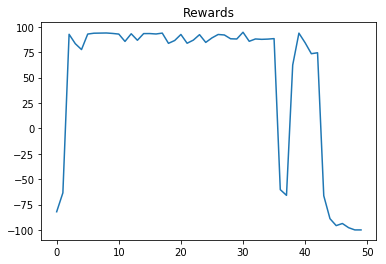

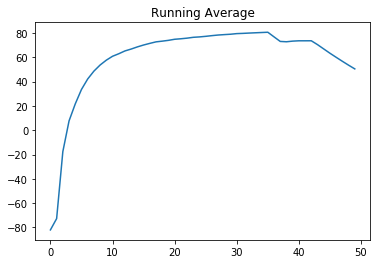

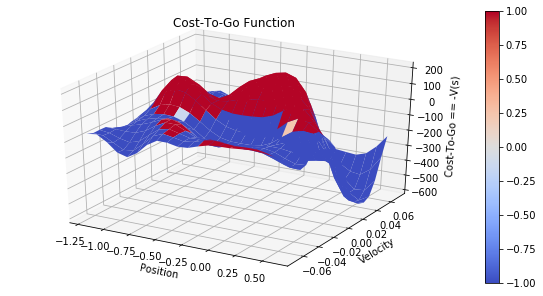

In [25]:
if __name__ == '__main__':
    main()